# Star-by-star systematics removal for PLATO

Each star is observed by J cameras for N observations. The flux for a given star in camera $j$, observation $i$, is:
$$
F_{ij} = \sum_l a_k A_{ik} \sum_l a_{jl} B_{il} + + \epsilon_{ij} 
$$
where the $A$'s are the stellar variability basis functions (same across all cameras), with coefficients $a$, the $B$'s are systematic trends, with coefficients $b$ (one set of coefficients for each camera), and the $\epsilon$'s are white Gaussian noise (with standard deviation $\sigma_{ij}$, though typically we will assume the same $\sigma$ for all $i$ for a given $j$).

The log likelihood for all the observations combined is:
$$
\log L = \mathrm{constant} - \sum_i \sum_j \left( \frac{F_{ij} - \sum_k a_k A_{ik} - \sum_l b_{jl} B_{il}}{\sigma_{ij}} \right)^2 = \mathrm{constant} - \chi^2
$$

As a very restricted preliminary test, try polynomials for both.


In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
%matplotlib inline

In [3]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

## Simuylate some data for one star

In [5]:
import numpy as np
import matplotlib.pylab as plt

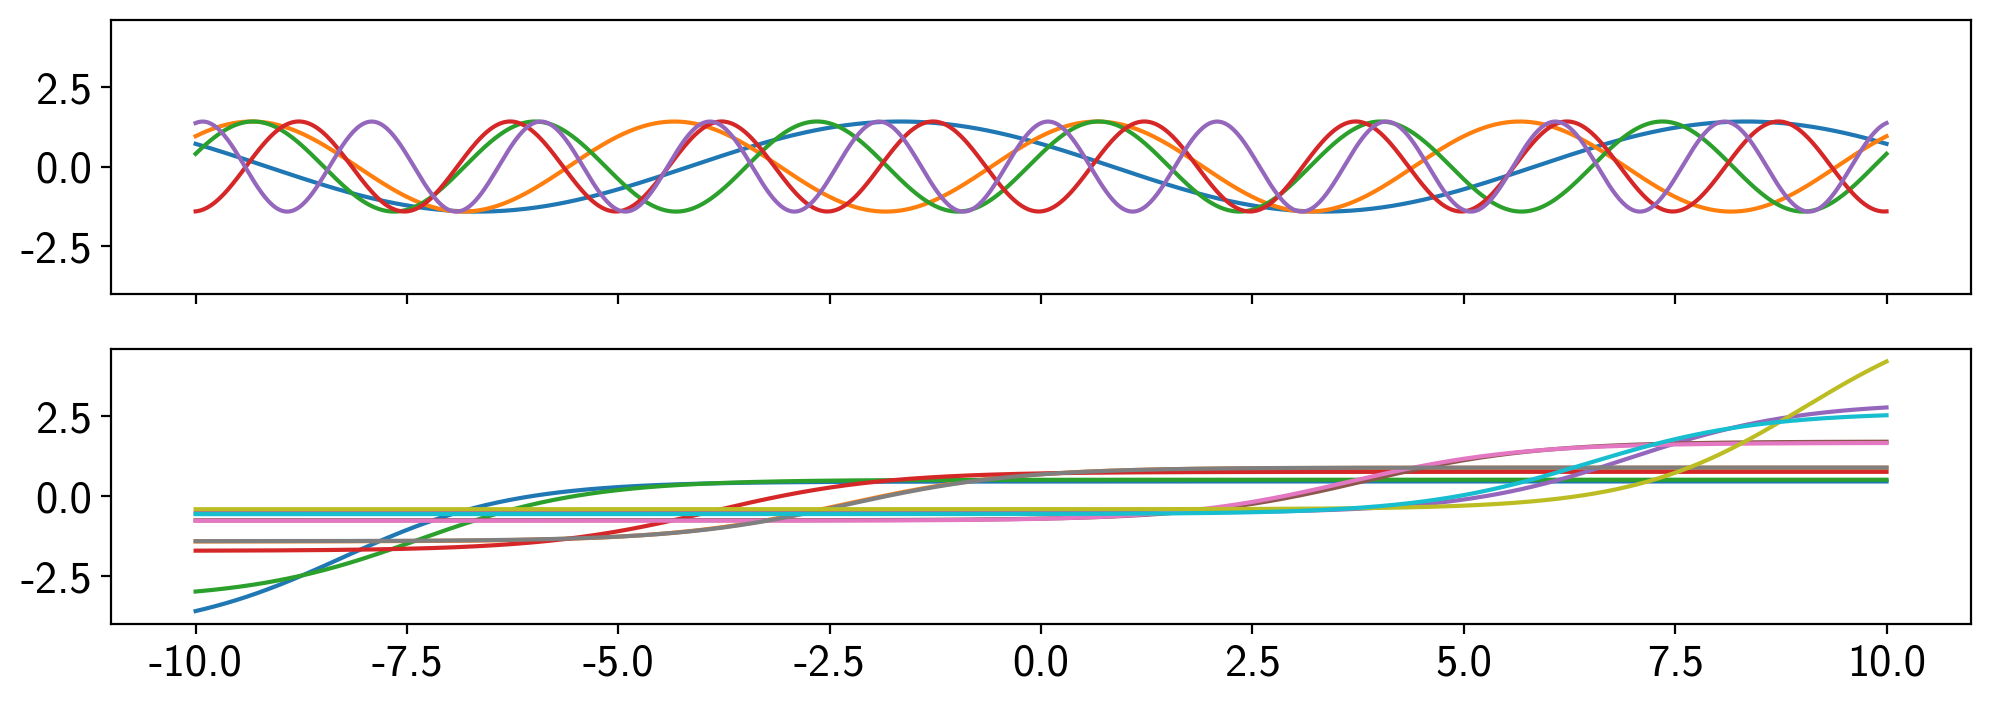

In [356]:
N = 1000
J = 5
K = 5
L = 10

A = np.zeros((K,N))
for k in range(K):
  p = max(t) / (k+1)
  ph = np.random.uniform(0,2*np.pi)
  tmp = np.sin(2 * np.pi * t / p + ph)
  tmp -= tmp.mean()
  A[k,:] = tmp / tmp.std()
fig, axes = plt.subplots(2,1, sharex = True, sharey=True)
axes[0].plot(t, A.T);

B = np.zeros((L,N))
t = np.linspace(-10,10,N)
for l in range(L):
  off = np.random.uniform(t.min(),t.max())
  x = t-off
  tmp = 1/(1 + np.exp(-x))
  tmp -= tmp.mean()
  B[l,:] = tmp / tmp.std()

axes[1].plot(t, B.T);


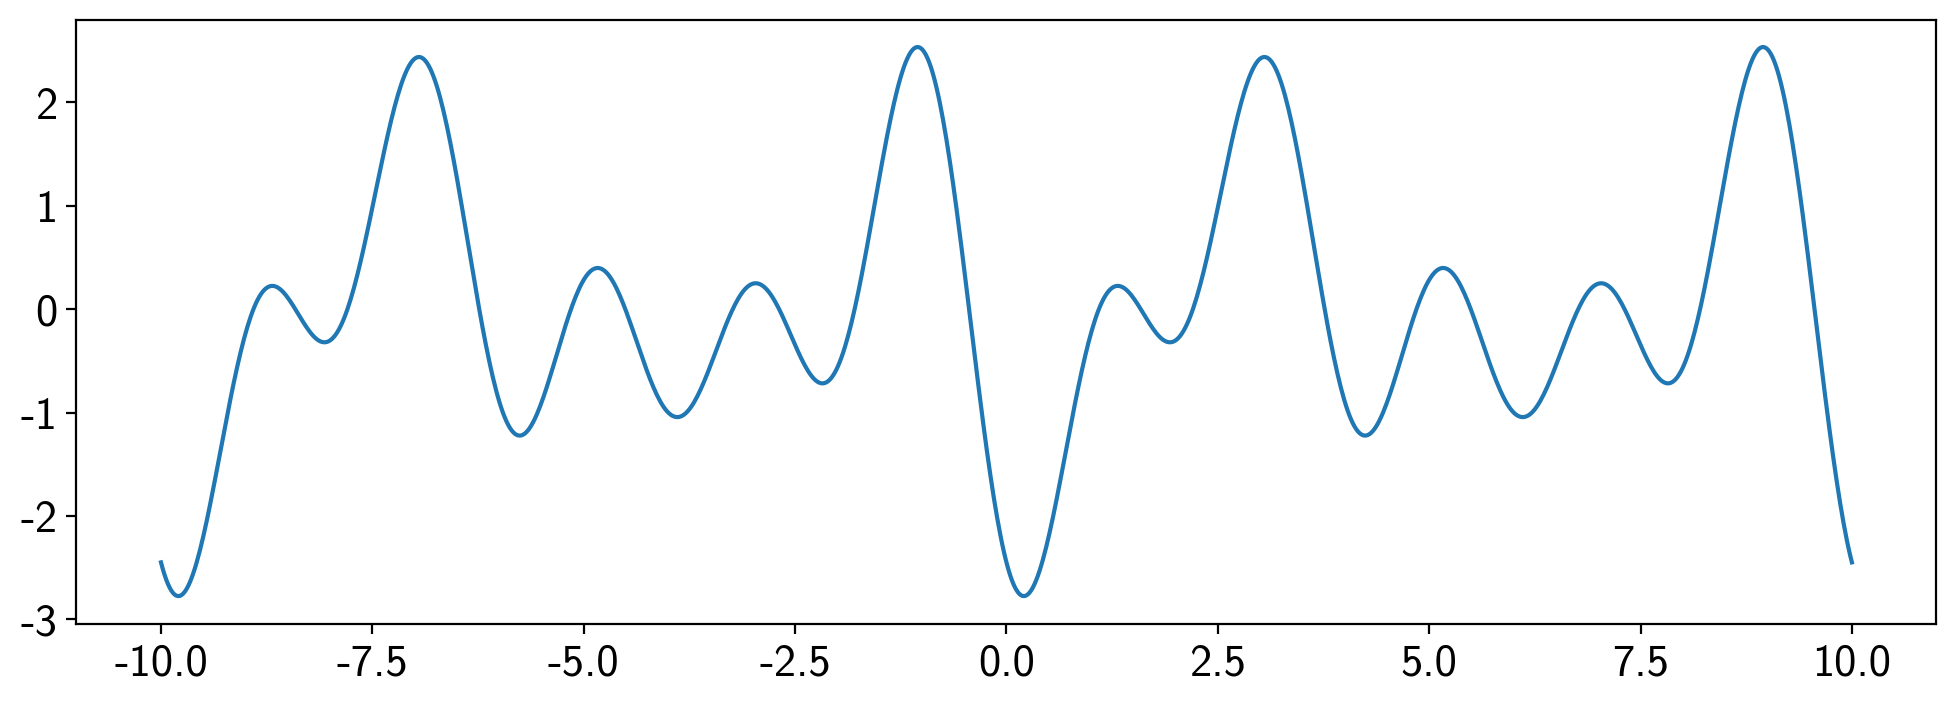

In [357]:
def get_Star(a):
  return np.dot(a, A)
a = np.random.uniform(-1,1,K)
Star = get_Star(a)
plt.plot(t,Star);


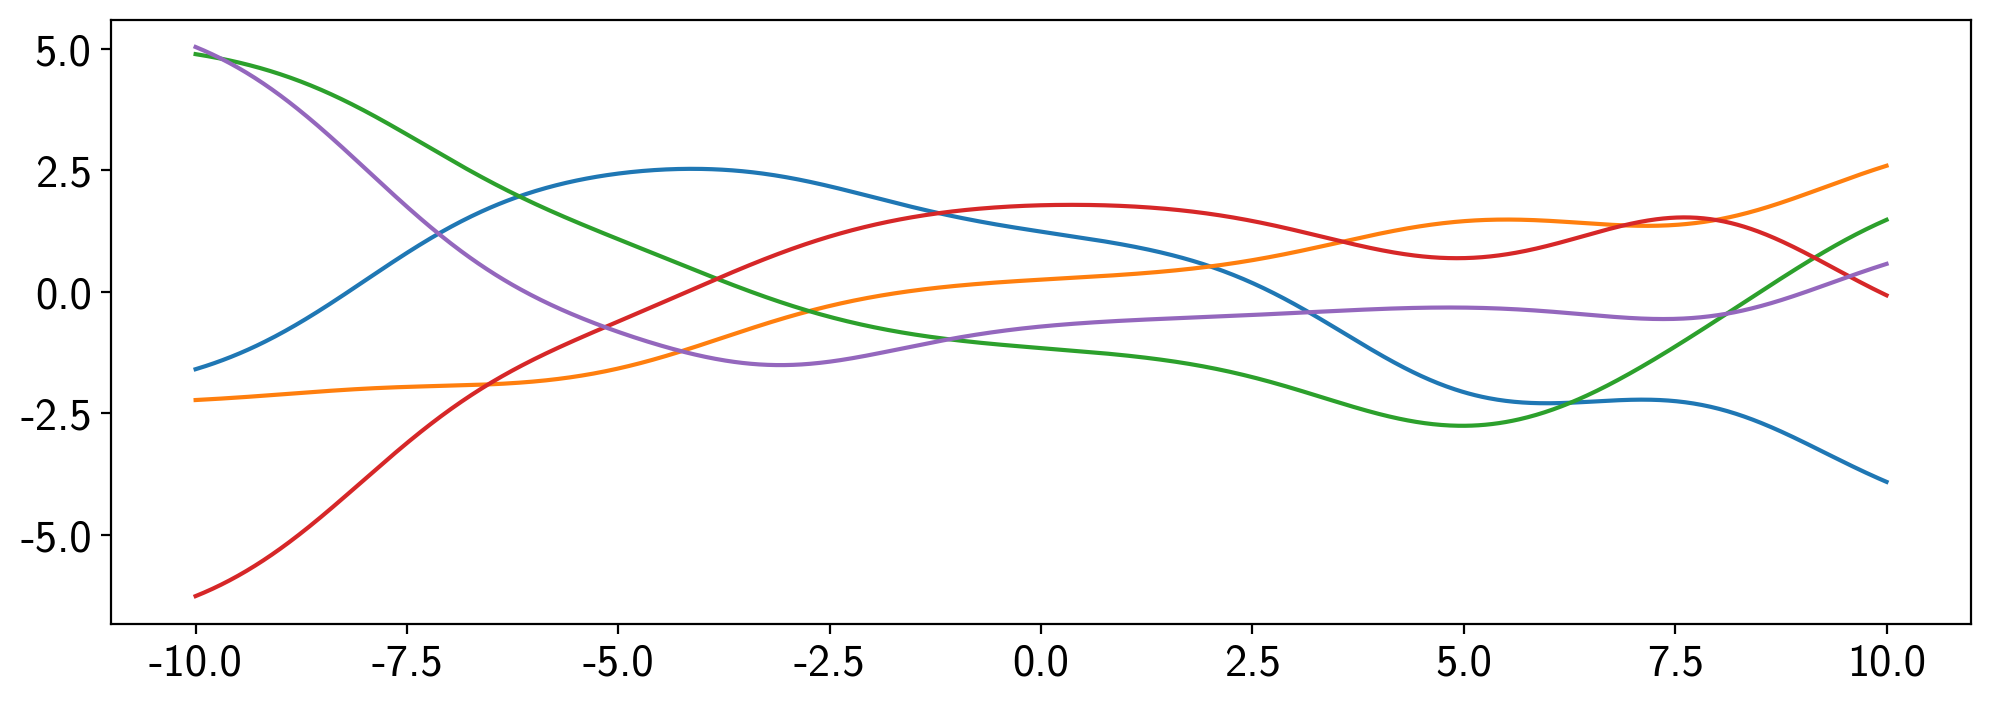

In [358]:
def get_Sys(b):
  Sys = np.zeros((J,N))
  for j in range(J):
    Sys[j,:] = np.dot(b[j,:],B) 
  return Sys
b = np.zeros((J,L))
for j in range(J):
  b[j,:] = np.random.uniform(-1,1,L)
Sys = get_Sys(b) 
plt.plot(t,Sys.T);

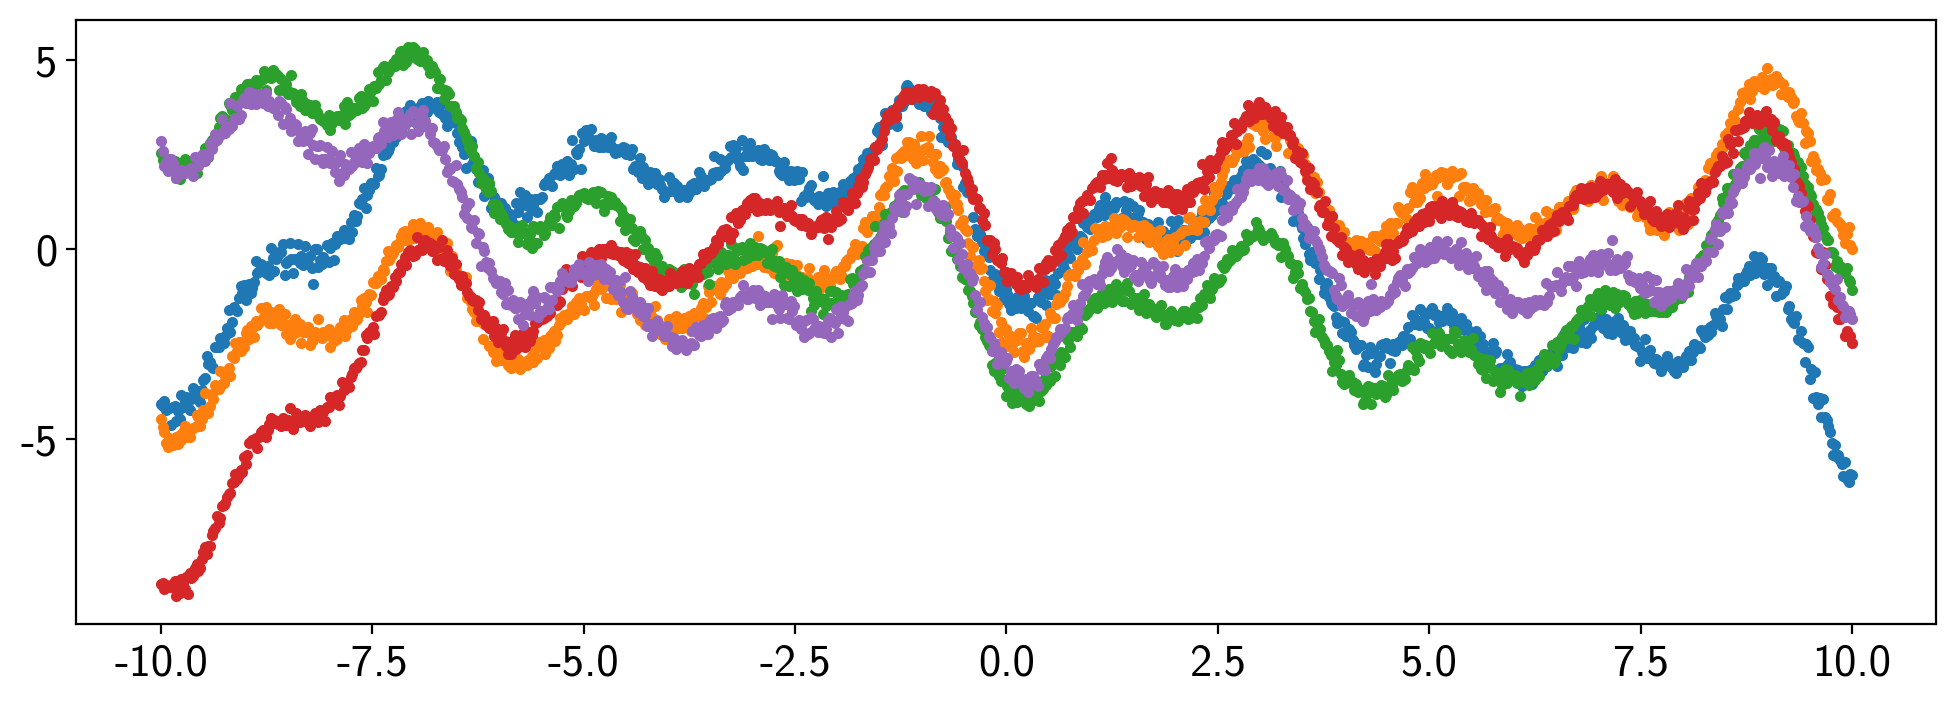

In [359]:
sig = np.random.uniform(0.1,0.2,J)
sigma = np.zeros((J,N)) + sig[:,None]
WN = np.random.normal(0,1,(J,N)) * sigma
F = Star[None,:] + Sys + WN
plt.plot(t,F.T,'.');

In [360]:
def get_Model(p):
  a = p[:K]
  b = p[K:].reshape((J,L))
  return get_Star(a)[None,:] + get_Sys(b)

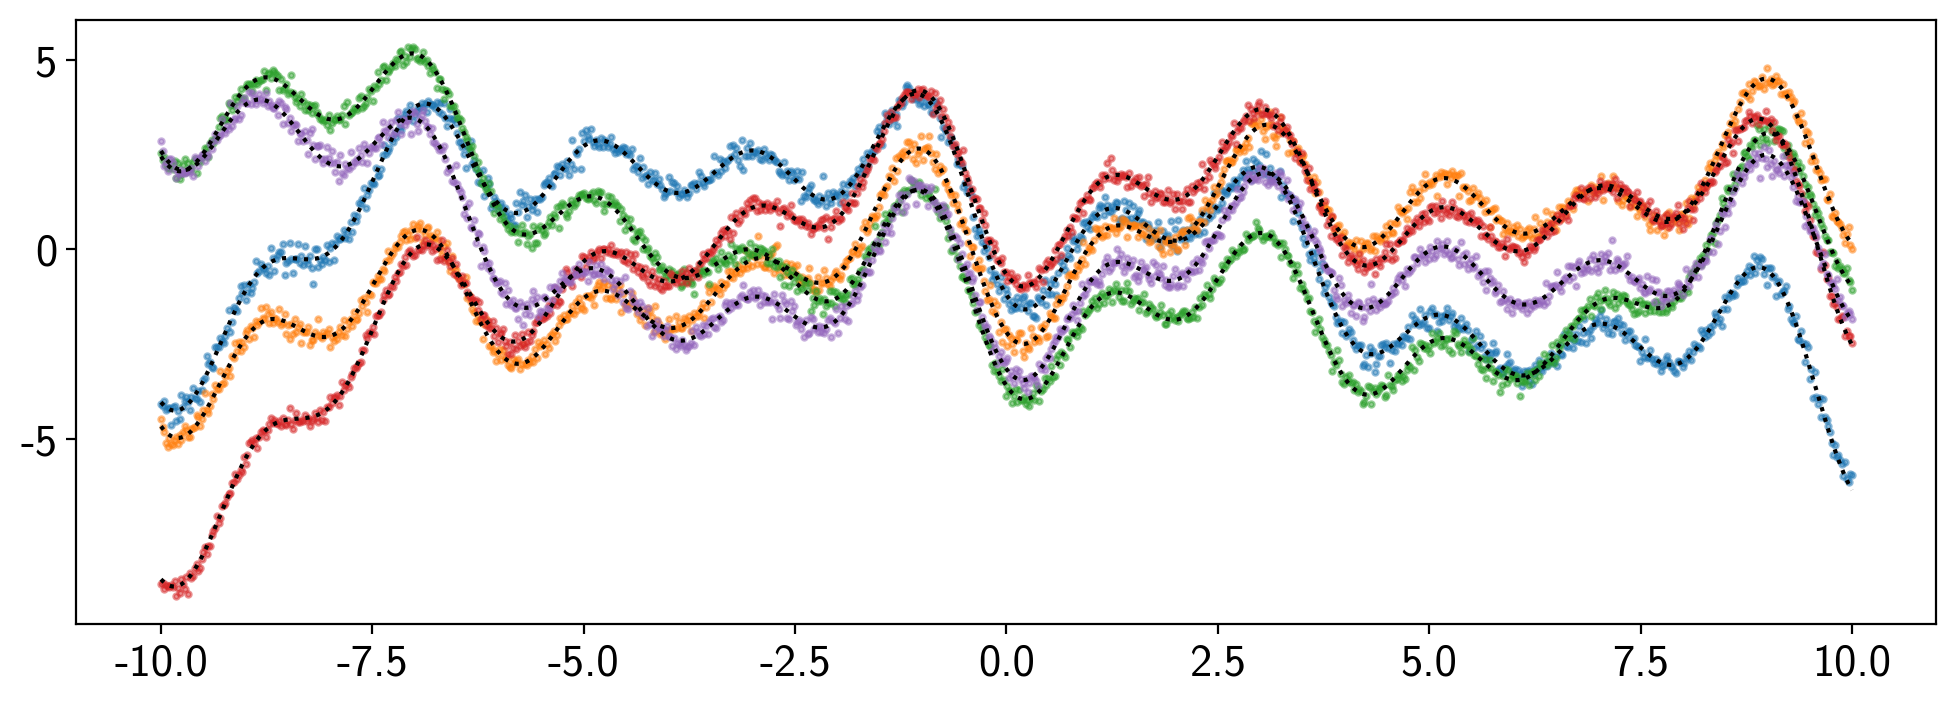

In [371]:
p_true = np.concatenate([a,b.flatten()])
M_true = get_Model(p_true)
plt.plot(t,F.T,'.',alpha=0.5,ms=4)
plt.plot(t,M_true.T,'k:');

# Solving for the coefficients

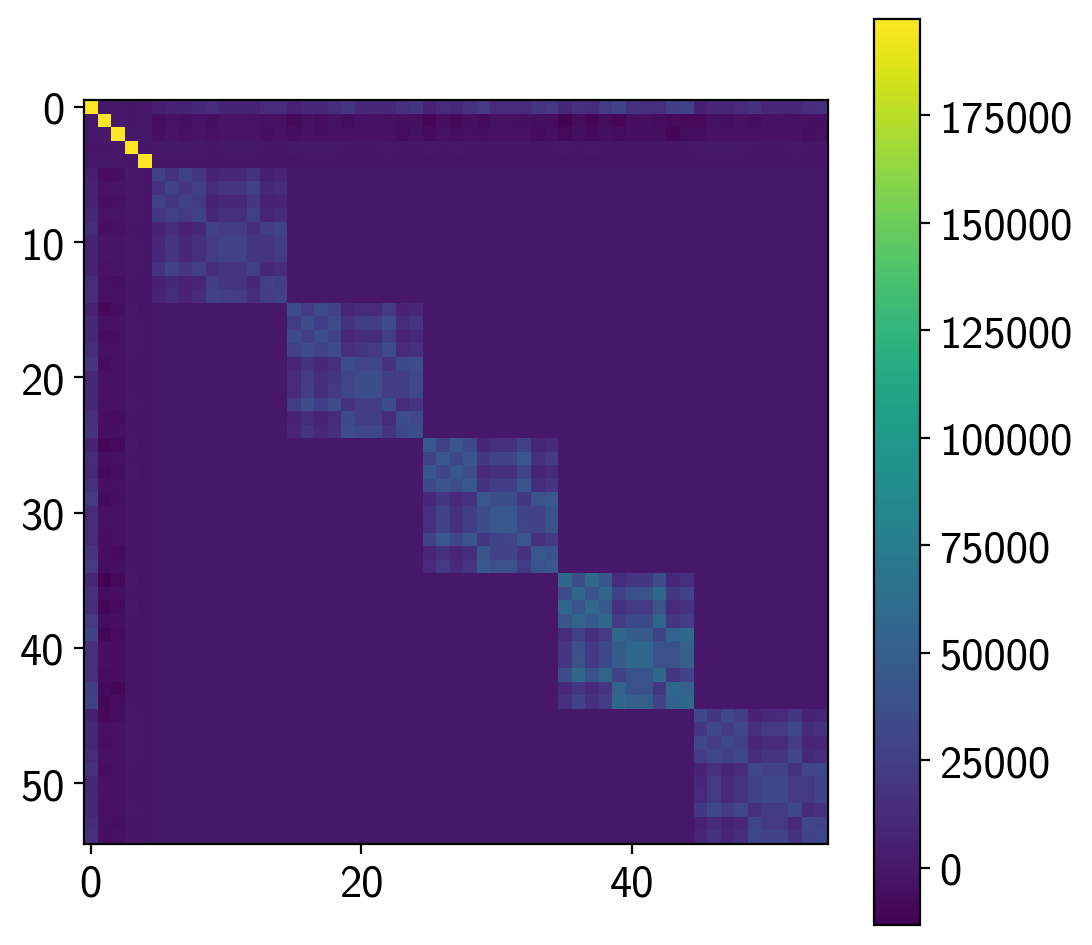

In [364]:
P = K + J * L
X = np.zeros((P,P))
X[:K,:K] = ((A[:,None,:] * A[None,:,:])[:,:,None,:] / (sigma[None,None,:,:])**2).sum(axis=-1).sum(axis=-1)
for j in range(J):
  D = ((A[:,None,:] * B[None,:,:]) / sigma[j,:]**2).sum(axis=-1)
  X[:K,K+j*L:K+(j+1)*L] = D
  X[K+j*L:K+(j+1)*L,:K] = D.T
  E = ((B[:,None,:] * B[None,:,:]) / sigma[j,:]**2).sum(axis=-1)
  X[K+j*L:K+(j+1)*L,K+j*L:K+(j+1)*L] = E
plt.figure(figsize=(6,6))
plt.imshow(X,interpolation='nearest')
plt.colorbar();

In [365]:
y = np.zeros(P)
y[:K] = (A[:,None,:] * (F / sigma**2)[None,:,:]).sum(axis=-1).sum(axis=-1)
for j in range(J):
  y[K+j*L:K+(j+1)*L] =  (B * (F / sigma**2)[None,j,:]).sum(axis=-1)
#print(y)

[   2313.99222804 -158765.68002218 -121544.84169992   54718.49943359
 -152299.50178184   10653.79076801  -26400.22211442    5165.86737462
  -17646.71882672  -36486.81618907  -44405.15167873  -44365.28929922
  -26701.03235197  -30475.64004783  -38355.55033722   43645.24311114
   52628.93871526   44240.48494832   51191.9002739    38932.77575518
   45476.03707856   46038.10603296   52623.33306544   34265.20804523
   39726.19699146  -67123.97729747  -74835.07901101  -74684.73474436
  -80551.81708372   -3902.88625431  -37036.44016827  -38623.56823819
  -74607.1560342     9409.60546236   -9170.51821546  131843.29183945
  103433.774803    130660.20659772  115789.40857824   37728.23479444
   49363.34442627   50609.426138    102898.29125348   27624.95872427
   39330.50778936  -38957.11394693  -20617.82140369  -40865.1844757
  -29104.30747089    1010.16591653   -4717.73559195   -4853.89266647
  -20355.6847463     3902.13614657    -188.8090763 ]


In [375]:
from numpy.linalg import svd
from scipy.linalg import cho_solve, cho_factor
U, w, V_T = svd(X,hermitian=True)
z = 1. / w
w_max = abs(w).max()
thresh = 1e-12 * w_max
small = w <= thresh
if small.any():
  print('Setting {} small singular values to zero'.format(small.sum()))
  z[w <= thresh] = 0.0
p_fit = np.dot(V_T.T, np.dot(np.diag(z), np.dot(U.T,y)))
print('typical error (star coeffs): {}'.format((p_fit-p_true)[:K].std()/K))
print('typical error (sys coeffs): {}'.format((p_fit-p_true)[K:].std()/(J*L)))

typical error (star coeffs): 0.0013694145779040714
typical error (sys coeffs): 0.032393466060301475


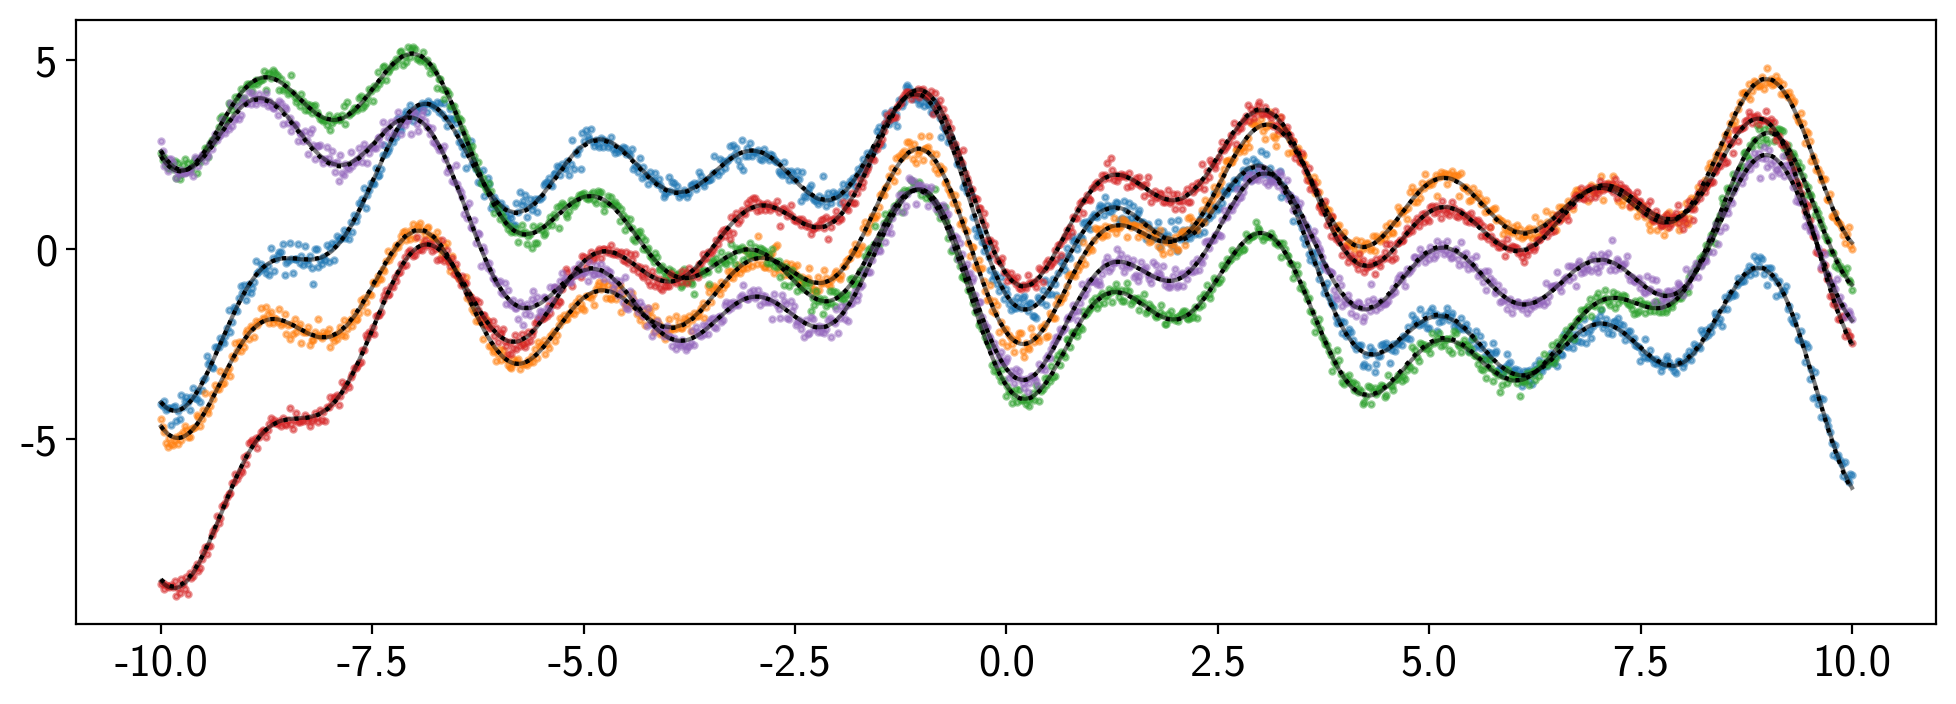

In [376]:
M_fit = get_Model(p_fit)
plt.plot(t,F.T,'.',alpha=0.5,ms=4)
plt.plot(t,M_fit.T,'k-',alpha=0.5);
plt.plot(t,M_true.T,'k:');
